### 🔧 Setup & Imports
We install and import all required libraries:
- **OpenCV** → for image handling.
- **NumPy** → for numerical operations.
- **face_recognition** → for embeddings and comparison.
- **Matplotlib** → for visualization.

In [1]:
!pip install --quiet face_recognition opencv-python matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 17.4 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done


In [2]:
import os, glob, pickle, pathlib
import cv2, numpy as np, face_recognition
import matplotlib.pyplot as plt

We also define a helper function `show_img()` to display images correctly (OpenCV loads images in BGR, so we convert to RGB for plotting).


In [3]:
def show_img(img, title=""):
    plt.figure(figsize=(6,6))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB) if img.ndim==3 else img, cmap=None if img.ndim==3 else "gray")
    plt.title(title); plt.axis("off"); plt.show()

### Loading Images

We load sample images of known and unknown persons.  
- These images will be used for detection, cropping, and embedding.  
- Displaying them first helps verify that images load correctly.

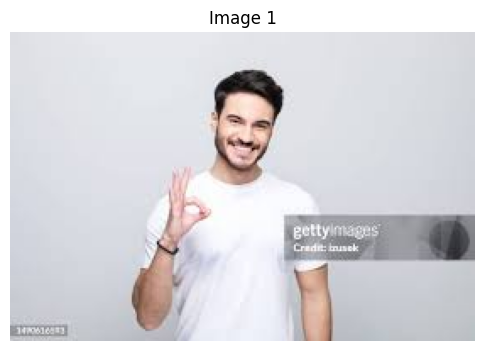

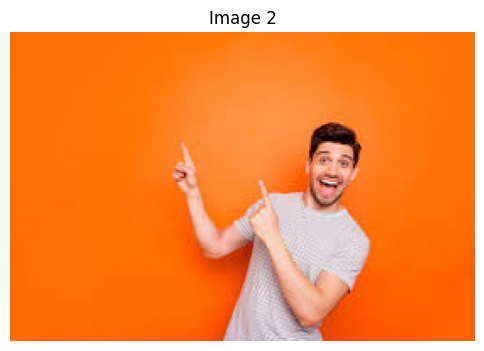

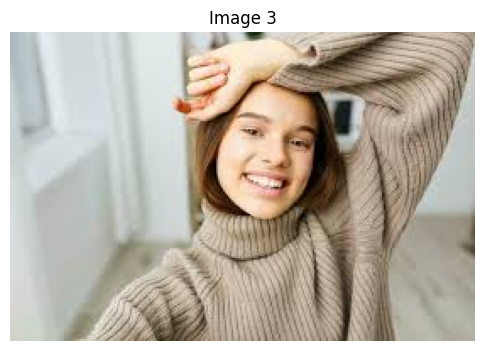

In [4]:
# Put your images in /kaggle/input/your-dataset/...
IMG1 = "/kaggle/input/face-dataset/1.jpeg"   
IMG2 = "/kaggle/input/face-dataset/2.jpeg"  
IMG3 = "/kaggle/input/face-dataset/3.jpeg"   

img1 = cv2.imread(IMG1); img2 = cv2.imread(IMG2); img3 = cv2.imread(IMG3)
show_img(img1, "Image 1"); show_img(img2, "Image 2"); show_img(img3, "Image 3")


### Face Detection
We detect face bounding boxes in each image.  
- `face_recognition.face_locations()` is used with the **HOG model** (CPU-based).  
- Each detected face is represented as a box `(top, right, bottom, left)`.  
- This step tells us **where the faces are** before extracting embeddings.


In [5]:
def detect_faces_bboxes_bgr(img, model="hog", upsample=1):
    # model: "hog" (CPU, faster) or "cnn" (needs dlib with CUDA)
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    boxes = face_recognition.face_locations(rgb, number_of_times_to_upsample=upsample, model=model)
    # boxes are (top, right, bottom, left)
    return boxes

b1 = detect_faces_bboxes_bgr(img1)
b2 = detect_faces_bboxes_bgr(img2)
b3 = detect_faces_bboxes_bgr(img3)

print("faces in img1/img2/img3:", len(b1), len(b2), len(b3))


faces in img1/img2/img3: 1 1 1


###  Cropping Faces
We crop faces from the original image using detected bounding boxes.  
- Useful for visualization and confirming that detection worked correctly.  
- Cropped faces can later be saved or used for embeddings.


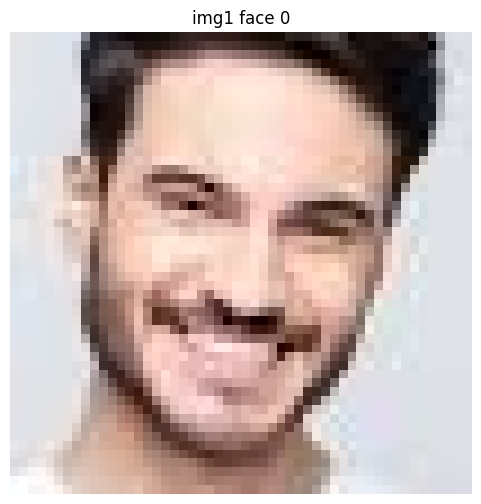

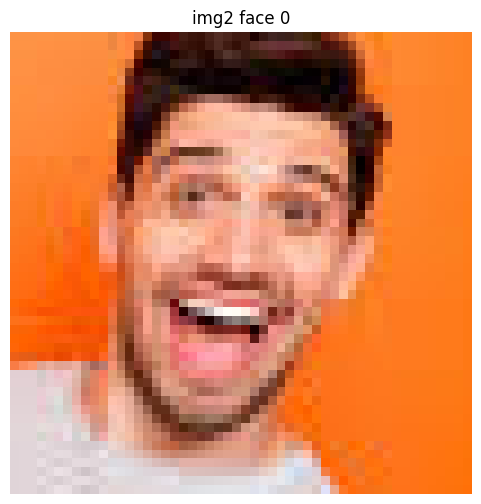

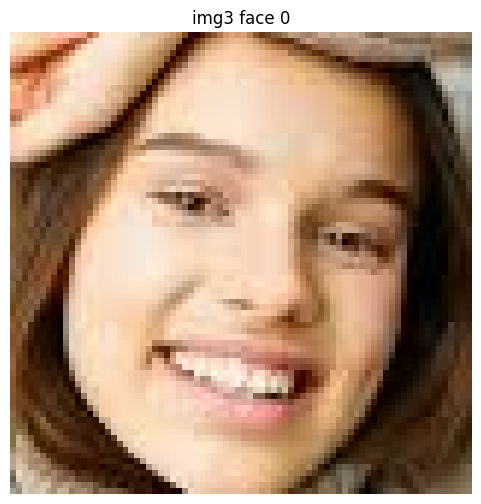

In [6]:
def crop_faces(img, boxes, pad=0):
    H,W = img.shape[:2]
    crops = []
    for (t,r,b,l) in boxes:
        t = max(0, t-pad); l = max(0, l-pad); b = min(H, b+pad); r = min(W, r+pad)
        crops.append(img[t:b, l:r].copy())
    return crops

crops1 = crop_faces(img1, b1, pad=8)
crops2 = crop_faces(img2, b2, pad=8)
crops3 = crop_faces(img3, b3, pad=8)

for i,c in enumerate(crops1): show_img(c, f"img1 face {i}")
for i,c in enumerate(crops2): show_img(c, f"img2 face {i}")
for i,c in enumerate(crops3): show_img(c, f"img3 face {i}")


### Face Embeddings
We convert detected faces into **128-dimensional embeddings** using `face_recognition.face_encodings()`.  
- These embeddings are numerical vectors that represent each person’s facial features.  
- They can be compared mathematically to check if two faces are the same person.


In [7]:
def embed_faces(img, boxes=None):
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # If boxes provided, encodings are faster & more stable
    enc = face_recognition.face_encodings(rgb, known_face_locations=boxes)
    return enc  # list of 128-D vectors

enc1 = embed_faces(img1, b1)
enc2 = embed_faces(img2, b2)
enc3 = embed_faces(img3, b3)

# Take the first face in each (adjust if multiple faces)
e1 = enc1[0] if enc1 else None
e2 = enc2[0] if enc2 else None
e3 = enc3[0] if enc3 else None

print("Embedding shapes:", None if e1 is None else len(e1),
      None if e2 is None else len(e2),
      None if e3 is None else len(e3))


Embedding shapes: 128 128 128


### 🔍 Face Comparison (Pairwise)
We compare embeddings between:
- Image 1 vs Image 2 (different person, should not match).
- Image 1 vs Image 3 (different people, should not match).  

We use **Euclidean distance**:
- Distance < 0.6 → likely same person.
- Distance ≥ 0.6 → different person.


In [12]:
def same_person(e_ref, e_query, threshold=0.6):
    # face_recognition uses Euclidean distance; lower = more similar
    dist = np.linalg.norm(e_ref - e_query)
    return (dist < threshold, float(dist))

m12, d12 = same_person(e1, e2)  # A vs A
m13, d13 = same_person(e1, e3)  # A vs B

print(f"A vs A -> match={m12}, distance={d12:.4f}")
print(f"A vs B -> match={m13}, distance={d13:.4f}")


A vs A -> match=False, distance=0.6391
A vs B -> match=False, distance=0.7882


### ⚡ Improving Robustness
A few tricks to improve accuracy:

- **Upsample small faces**: Detect smaller faces by increasing `upsample` value.
- **Adjust threshold**: Lower threshold (<0.6) for stricter matching.
- **Average embeddings**: Use multiple images per person and average their embeddings for stability.
